# Fraud Detection with RAPIDS

Complete following setup before running this notebook： 

- Server with 1 * A100 GPU, CUDA 11.x, and docker
- Get "<b>IEEE-CIS Fraud Detection</b>" dataset
    * Go to https://www.kaggle.com/c/ieee-fraud-detection/data, download dataset and unzip to `./dataset` folder
- Get RAPIDS docker image：`docker pull nvcr.io/nvidia/rapidsai/rapidsai:22.06-cuda11.2-runtime-ubuntu20.04-py3.8`
- Run docker: 

```bash
docker run --gpus '"device=0"' -it --rm --network=host --shm-size=24g   --ulimit memlock=-1 --ulimit stack=67108864 \
-v /home:/home   \
nvcr.io/nvidia/rapidsai/rapidsai:22.06-cuda11.2-runtime-ubuntu20.04-py3.8 /bin/bash
```

- Inside docker, start jupyter lab: `jupyter-lab --allow-root --ip=0.0.0.0 --no-browser --NotebookApp.token=''`


In [1]:
import os
from glob import glob
import time # to measure time

import pandas as pd # CPU
import cudf # GPU ##

import xgboost as xgb # model

from tqdm import tqdm # to display progress bar

# CPU
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# GPU ##
from cuml.preprocessing import LabelEncoder as gpu_LabelEncoder
from cuml.model_selection import train_test_split as gpu_train_test_split


# visualisation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import plot_importance, plot_tree


In [2]:
data_root = "./dataset"

filenames = glob(os.path.join(data_root, "*.csv"))        
fp_train_trans = filenames[4]
fp_train_ident = filenames[0]
filenames

['./dataset/test_identity.csv',
 './dataset/train_identity.csv',
 './dataset/sample_submission.csv',
 './dataset/test_transaction.csv',
 './dataset/train_transaction.csv']

# 1. Load Data

In [3]:
%%time

# CPU
train_transaction = pd.read_csv(fp_train_trans, index_col="TransactionID")
train_identity = pd.read_csv(fp_train_ident, index_col="TransactionID")

CPU times: user 25.1 s, sys: 4.91 s, total: 30 s
Wall time: 30.1 s


In [4]:
%%time

# GPU
train_transaction_gpu = cudf.read_csv(fp_train_trans, index_col="TransactionID")
train_identity_gpu = cudf.read_csv(fp_train_ident, index_col="TransactionID")

CPU times: user 2.58 s, sys: 516 ms, total: 3.1 s
Wall time: 4.5 s


In [5]:
# look at the first 5 rows of the df
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_identity.head()

,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


**Merge dataframes**

* We merge the original (left) dataframe with another (right)
* `left`: use the keys from left frame, similar to a SQL left outer join; preserve key order
* `left_index` and `right_index`: use the index from the left and right dataframes as the join keys

In [7]:
%%time

# CPU
train_data = train_transaction.merge(train_identity, how="left", left_index=True, right_index=True)

CPU times: user 740 ms, sys: 992 ms, total: 1.73 s
Wall time: 1.73 s


In [8]:
%%time

# GPU
train_data_gpu = train_transaction_gpu.merge(train_identity_gpu, how="left", left_index=True, right_index=True)

CPU times: user 68 ms, sys: 84 ms, total: 152 ms
Wall time: 152 ms


In [9]:
# CPU
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


In [10]:
# GPU
train_data_gpu.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 590540 entries, 3007864 to 3575459
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


In [11]:
# CPU
# datetime of transaction probably doesn't matter
train_data.drop(["TransactionDT"], axis=1, inplace=True) # remove column from df

# label
y = train_data["isFraud"].astype("int") # convert to int dtype
y.head()

TransactionID
2987000    0
2987001    0
2987002    0
2987003    0
2987004    0
Name: isFraud, dtype: int64

In [12]:
# GPU
train_data_gpu.drop(["TransactionDT"], axis=1, inplace=True) # remove column from df

# label
y_gpu = train_data_gpu["isFraud"].astype("int") # convert to int dtype
y_gpu.head()

TransactionID
3007864    0
3007865    0
3007866    0
3007867    0
3007868    0
Name: isFraud, dtype: int64

In [13]:
# CPU
# features (data)
x = train_data.drop("isFraud", axis=1) # remove label from feature set
# xgboost can handle missing data as a seperate case
# you can also fill in missing values
#x = x.fillna(-999.0) #  large negative number simulates null/missing values

# counters
converted_to_float = 0
converted_to_categorical = 0
dropped = 0

for col in tqdm(x.columns): # displays progress bar
    try:
        x[col] = x[col].astype("float") # convert column to float dtype
        converted_to_float += 1
    except:
        #try:
        le = LabelEncoder()
        x_col = x[col].str.lower() # change string to lowercase
        new_col = le.fit_transform(x_col) # transform non-numerical values (0 to n)
        x[col] = new_col.astype("float")
        converted_to_categorical += 1
        #except:
        #    x.drop([col], axis=1, inplace=True)
        #    dropped += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 431/431 [06:09<00:00,  1.17it/s]


In [18]:
# GPU
# features (data)
x_gpu = train_data_gpu.drop("isFraud", axis=1) # remove label from feature set

# counters
converted_to_float = 0
converted_to_categorical = 0
dropped = 0

for col in tqdm(x_gpu.columns): # displays progress bar
    try:
        x_gpu[col] = x_gpu[col].astype("float") # convert column to float dtype
        converted_to_float += 1
    except:
        #try:
        le_gpu = gpu_LabelEncoder() # GPU version
        x_col_gpu = x_gpu[col].str.lower() # change string to lowercase
        new_col_gpu = le_gpu.fit_transform(x_col_gpu) # transform non-numerical values (0 to n)
        x_gpu[col] = new_col_gpu.astype("float")
        converted_to_categorical += 1
        #except:
        #    x_gpu.drop([col], axis=1, inplace=True)
        #    dropped += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 431/431 [00:00<00:00, 996.36it/s]


In [14]:
x.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,68.5,4.0,13926.0,NaN,150.0,1.0,142.0,1.0,315.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,29.0,4.0,2755.0,404.0,150.0,2.0,102.0,1.0,325.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,59.0,4.0,4663.0,490.0,150.0,3.0,166.0,2.0,330.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,50.0,4.0,18132.0,567.0,150.0,2.0,117.0,2.0,476.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,50.0,1.0,4497.0,514.0,150.0,2.0,102.0,1.0,420.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print("converted_to_float:", converted_to_float)
print("converted_to_categorical:", converted_to_categorical)
print("cols dropped:", dropped)

converted_to_float: 417
converted_to_categorical: 14
cols dropped: 0


# 2. Train Model

In [20]:
%%time

# CPU
# Make train test split
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, stratify=y)

CPU times: user 2.72 s, sys: 1.87 s, total: 4.59 s
Wall time: 4.58 s


In [21]:
%%time

# GPU
# Make train test split
X_train_gpu, X_valid_gpu, y_train_gpu, y_valid_gpu = gpu_train_test_split(x_gpu, y_gpu, test_size=0.1, stratify=y_gpu)

CPU times: user 608 ms, sys: 568 ms, total: 1.18 s
Wall time: 1.81 s


In [22]:
del x, train_data, train_transaction, train_identity, x_gpu, train_data_gpu, train_transaction_gpu, train_identity_gpu
!free -h
# !nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:          125Gi        66Gi       6.0Gi       9.6Gi        53Gi        48Gi
Swap:            0B          0B          0B


In [23]:
print("CPU")
print("Train:", X_train.shape, y_train.shape)
print(" Test:", X_valid.shape, y_valid.shape)
print("*"*10)

print("GPU")
print("Train:", X_train_gpu.shape, y_train_gpu.shape)
print(" Test:", X_valid_gpu.shape, y_valid_gpu.shape)

CPU
Train: (531486, 431) (531486,)
 Test: (59054, 431) (59054,)
**********
GPU
Train: (531486, 431) (531486,)
 Test: (59054, 431) (59054,)


In [24]:
# get ratio of positive cases (1) to negative cases (0)
ratio_of_positive = y_train.sum()/(len(y_train)-y_train.sum())
print(round(ratio_of_positive,3), ": 1 ratio of positive:negative")

0.036 : 1 ratio of positive:negative


Construct the XGBoost Classifier. You can also try out [additional arguments](https://xgboost.readthedocs.io/en/latest/parameter.html) to perform parameter tuning.

In [25]:
# CPU
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    tree_method="hist",
    # scale up the weight of positive samples
    scale_pos_weight=1/ratio_of_positive,
    use_label_encoder=False
)

In [26]:
# GPU
model_gpu = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    tree_method="gpu_hist",
    # scale up the weight of positive samples
    scale_pos_weight=1/ratio_of_positive,
    use_label_encoder=False
)

In [27]:
# CPU
train_start_time = time.time()

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          verbose=False)

train_end_time = time.time()

results = model.evals_result()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Training takes: 62 seconds


In [30]:
# GPU
train_start_time = time.time()

model_gpu.fit(X_train_gpu, y_train_gpu,
          eval_set=[(X_train_gpu, y_train_gpu), (X_valid_gpu, y_valid_gpu)],
          verbose=False)

train_end_time = time.time()

results_gpu = model_gpu.evals_result()

print("Training takes:", int(train_end_time-train_start_time), "seconds")

Training takes: 9 seconds


# 3. Evaluation

In [28]:
%%time

# CPU
preds = model.predict(X_valid)

CPU times: user 2.15 s, sys: 28 ms, total: 2.18 s
Wall time: 108 ms


In [31]:
%%time

# GPU
preds_gpu = model_gpu.predict(X_valid_gpu)

CPU times: user 480 ms, sys: 12 ms, total: 492 ms
Wall time: 489 ms


# 4. Visualization

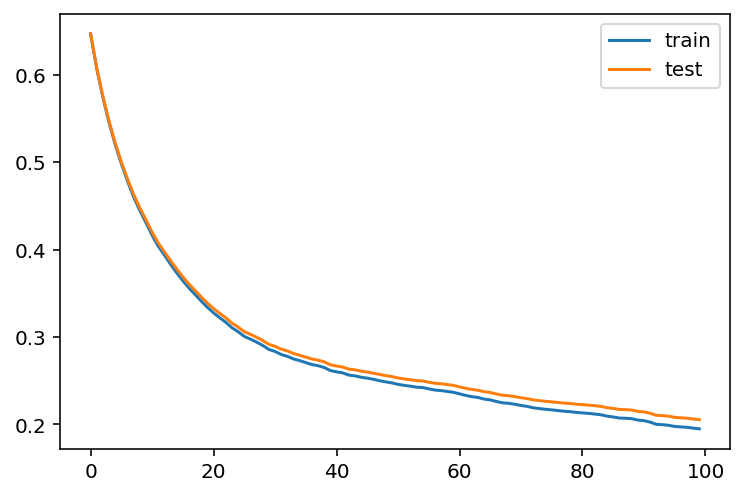

In [32]:
# CPU
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

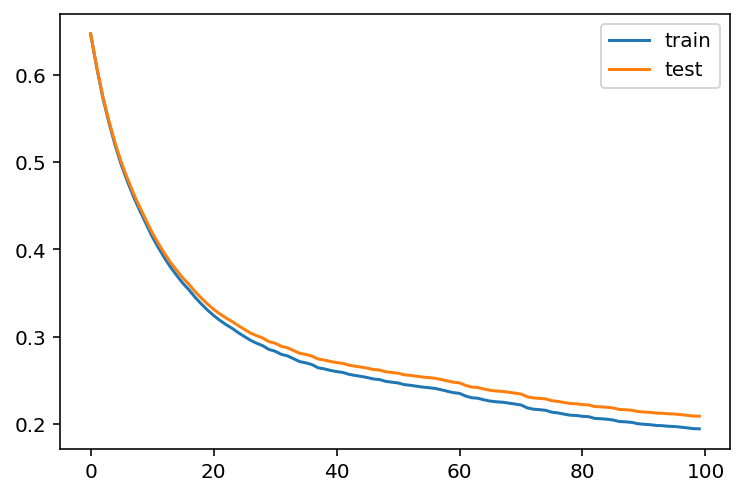

In [33]:
# GPU
# plot learning curves
plt.plot(results_gpu['validation_0']['logloss'], label='train')
plt.plot(results_gpu['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

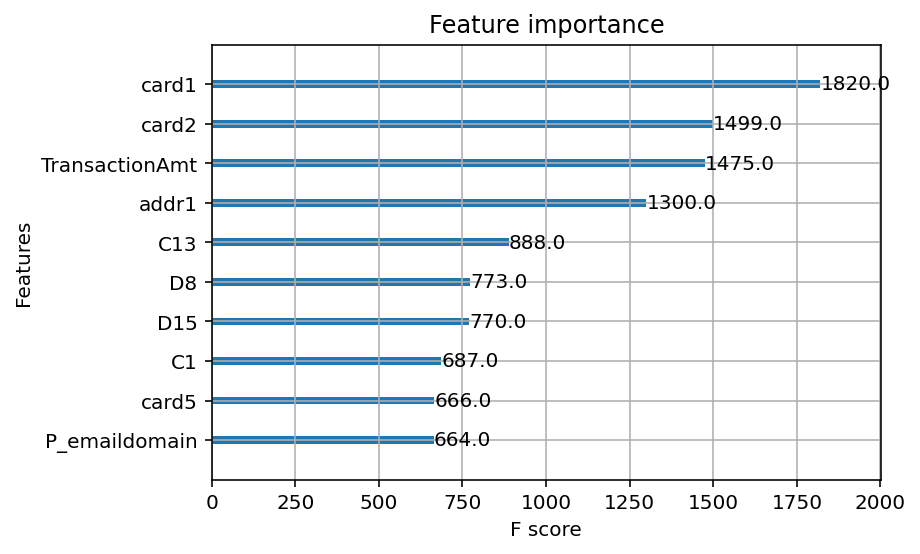

In [35]:
# CPU
# plot feature importance

plot_importance(model, max_num_features=10)
plt.show()

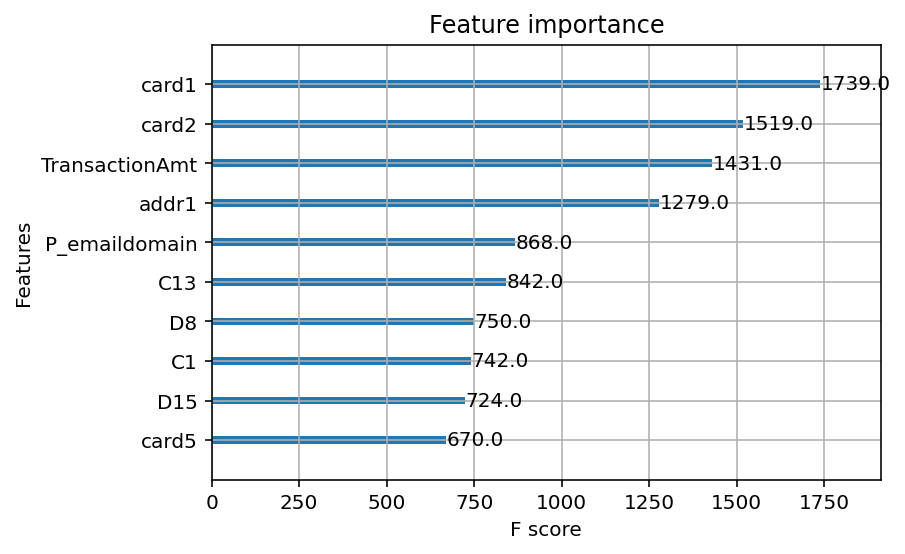

In [36]:
# GPU
# plot feature importance

plot_importance(model_gpu, max_num_features=10)
plt.show()